In [1]:
import numpy as np
import numpy.ma as ma
import argparse
import sys
sys.path.append("./utils/")
import operator_calculations as op_calc
import delay_embedding as embed
import stats
from scipy.interpolate import UnivariateSpline
from multiprocessing import Pool,cpu_count
import pickle
import h5py
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.io import loadmat

In [2]:
frameRate=16.
data_dt=1/frameRate

ctraj_path = '../data/Foraging_N2/ctrajs_1000_clusters/'
f = h5py.File(ctraj_path+'/c_traj_w.h5','r')
mD = f['MetaData']
n_clusters = np.array(mD['n_clusters'],dtype=int)[0]
delay = np.array(mD['delay'],dtype=int)[0]
ctraj_w = ma.array(f['ctraj_w'])
ctraj_w_mask = ma.array(f['ctraj_w_mask'])
f.close()
ctraj_w[ctraj_w_mask==1]=ma.masked

# Reconstruction error

In [3]:
n_sims=1000
delta_hs = []
for k in range(n_sims):
    f = h5py.File('../data/Foraging_N2/optimize_h/delta_h_{}.h5'.format(k),'r')        
    delta_h = np.array(f['delta_h'])
    h_range = np.array(f['h_range'])
    dx = np.array(f['dx'])[0]
    stride = np.array(f['stride'])[0]
    f.close()
    delta_hs.append(delta_h)

In [4]:
mean_D1 = ma.compress_rows(ma.diff(ma.masked_invalid(np.array(delta_hs)[:,:,0]),axis=1)).mean(axis=0)
cil_D1 = np.percentile(ma.compress_rows(ma.diff(ma.masked_invalid(np.array(delta_hs)[:,:,0]),axis=1)),2.5,axis=0)
ciu_D1 = np.percentile(ma.compress_rows(ma.diff(ma.masked_invalid(np.array(delta_hs)[:,:,0]),axis=1)),97.5,axis=0)

In [5]:
mean_D1,cil_D1,ciu_D1 = stats.bootstrap(np.diff(ma.masked_invalid(np.array(delta_hs)[:,:,0]),axis=1),n_times=1000)
mean_D2,cil_D2,ciu_D2 = stats.bootstrap(np.diff(ma.masked_invalid(np.array(delta_hs)[:,:,1]),axis=1),n_times=1000)

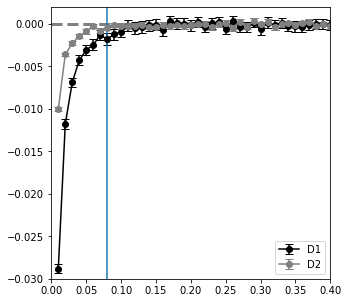

In [6]:
plt.figure(figsize=(5,5))
plt.errorbar(h_range[:-1],mean_D1,yerr = [mean_D1-cil_D1,ciu_D1-mean_D1],capsize=4,marker='o',c='k',label='D1')
plt.errorbar(h_range[:-1],mean_D2,yerr = [mean_D2-cil_D2,ciu_D2-mean_D2],capsize=4,marker='o',c='gray',label='D2')
plt.legend()
plt.axhline(0,ls='--',c='gray',lw=3)
plt.axvline(0.08)
plt.xlim(0,0.4)
plt.ylim(-.03,0.002)
# plt.savefig('delta_hs.pdf')
plt.show()

# Noise correlations

In [7]:
f = h5py.File('../data/Foraging_N2/noise_correlations/eps_sims.h5','r')
print(f.keys())
eps_sim = np.array(f['eps_sim'])
wsize = np.array(f['wsize'])[0]
h = np.array(f['h'])[0]
dx = np.array(f['dx'])[0]
stride = np.array(f['stride'],dtype=int)[0]
f.close()

<KeysViewHDF5 ['dx', 'eps_sim', 'h', 'stride', 'wsize']>


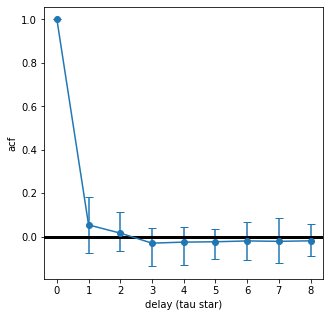

In [8]:
lags = np.arange(0,100,stride)
Cs=[]
for eps in eps_sim:
    Cs.append(stats.acf(eps,lags))
mean = np.mean(Cs,axis=0)
cil = np.percentile(Cs,2.5,axis=0)
ciu = np.percentile(Cs,97.5,axis=0)

plt.figure(figsize=(5,5))
plt.errorbar(lags*data_dt,mean,yerr = [mean-cil,ciu-mean],marker='o',capsize=4)
plt.axhline(0,c='k',lw=3)
plt.xticks(np.arange(0,9*stride,stride)*data_dt,np.arange(0,9))
plt.xlabel('delay (tau star)')
plt.ylabel('acf')
# plt.savefig('noise_correlations.pdf')
plt.show()